![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('final.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   40000 non-null  int64  
 1   id           40000 non-null  object 
 2   city         40000 non-null  object 
 3   cuisine      40000 non-null  object 
 4   ranking      40000 non-null  float64
 5   rating       40000 non-null  float64
 6   nor          40000 non-null  float64
 7   reviews      40000 non-null  object 
 8   url_ta       40000 non-null  object 
 9   id_ta        40000 non-null  object 
 10  prcat        40000 non-null  float64
 11  col_cuisine  40000 non-null  object 
 12  col_c        40000 non-null  int64  
 13  city_le      40000 non-null  int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 4.3+ MB


In [7]:
df_train.head(5)

,Unnamed: 0,id,city,cuisine,ranking,rating,nor,reviews,url_ta,id_ta,prcat,col_cuisine,col_c,city_le
0,0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,2.0,"['European', 'French', 'International']",3,24
1,1,id_1535,Stockholm,Unknown,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,2.0,"['Asian', 'Nepali']",2,27
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,3.0,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",7,16
3,3,id_3456,Berlin,Unknown,3458.0,5.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,2.0,[],0,3
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,2.0,"['German', 'Central European', 'Vegetarian Fri...",3,21


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [8]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             10000 non-null  float64
 11  Unnamed: 0         40000 non-null  float64
 12  id                 40000 non-null  object 
 13  city               40000 non-null  object 
 14  cuisine            40000 non-null  object 
 15  ranking            40000 non-null  float64
 16  rating             400

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,ranking,rating,nor,reviews,url_ta,id_ta,prcat,col_cuisine,col_c,city_le
34774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,819.0,4.5,11.0,"[['Secret is in the sauce', 'Using your Noodle...",/Restaurant_Review-g189541-d9714280-Reviews-1_...,d9714280,1.0,['Chinese'],1.0,7.0
44664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,1098.0,4.0,283.0,"[[], []]",/Restaurant_Review-g187791-d10221942-Reviews-T...,d10221942,2.0,['Italian'],1.0,26.0
46602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,1669.0,4.5,21.0,"[['great little restaurant', 'Small cozy place...",/Restaurant_Review-g188590-d3749051-Reviews-Ee...,d3749051,2.0,"['European', 'Italian', 'Pizza']",3.0,0.0
11461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,8279.0,4.5,10.0,"[['Yoo need to go!', 'Quick'], ['09/20/2017', ...",/Restaurant_Review-g186338-d11444358-Reviews-Y...,d11444358,2.0,"['Japanese', 'Brazilian', 'Sushi', 'South Amer...",4.0,16.0
24361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,5741.0,5.0,2.0,"[[], []]",/Restaurant_Review-g187791-d5813216-Reviews-Te...,d5813216,2.0,[],0.0,26.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

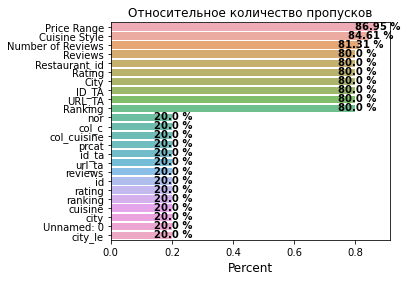

In [15]:
# Считаем процент пропусков
per_nans = pd.DataFrame(1-data.count()/data.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
# Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize = (5, 4))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Очистка и обработка признаков

# Restaurant_id

In [16]:
data['Restaurant_id'].value_counts()

id_9904    1
id_8387    1
id_8964    1
id_5746    1
id_6074    1
          ..
id_8535    1
id_7210    1
id_2684    1
id_3999    1
id_114     1
Name: Restaurant_id, Length: 10000, dtype: int64

Некоторые id встречаются более 1 раза, что может быть всязано с тем, что они являются сетевыми. Создадим новый признак chain: 1 - ресторан сетевой, 0 - нет.

In [17]:
chain_lst = list(data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts() > 1].index)
data['chain'] = data[data.Restaurant_id.isin(chain_lst)].Restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)
data['chain'] = data['chain'].astype(int)

# City

Посмотрим на распределение рейтингов по городам

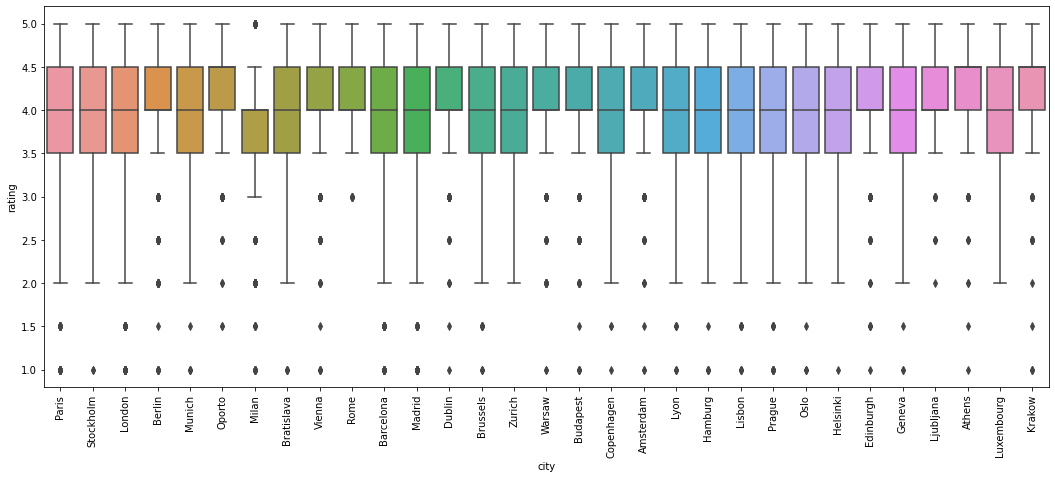

In [18]:
plt.figure(figsize=(18, 7))
sns.boxplot(x='city', y='rating', data=data[data['sample'] == 1])
plt.xticks(rotation=90);

### Number of reviews

In [19]:
# Обработаем пропуски столбца Number of Reviews - создадим дополнительный столбец
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [20]:
# Заполним пропуски нулями, предполагая, что NaN может обозначать отсутствие отзывов
data['Number of Reviews'].fillna(0, inplace=True)

### Price Range

In [21]:
data['Price Range'].value_counts()

$$ - $$$    4629
$           1537
$$$$         359
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [22]:
# Создадим дополнительный столбец Price_Range_isNAN
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
# Заменим Price Range числами, при этом попробуем заменить NAN на 2 - самую часто встречающуюся ценовую категорию
replace_price_range = {'Price Range': {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}}
data.replace(replace_price_range, inplace=True)

### Cuisine Style

In [23]:
# Также создадим столбец, содержащий информацию о пропусках
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [24]:
# Заменим пропуски на Unknown
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Unknown']")

In [25]:
def cuisine (df):
    # Приводим все названия кухонь к одному формату.
    df['Cuisine Style'] = df['Cuisine Style'].str.lower()

    # Делаем преобразования.
    cuisineStyle = set()
    cuisines = df['Cuisine Style'].to_list()

    # Заполняем сет для получения уникальных значений.
    # А так же создаем список
    for cuisine in cuisines:
        cuisine = re.findall(r"'([\s\S]+?)'", cuisine)
        for j in cuisine:
            cuisineStyle.add(j)
    
    for item in cuisineStyle:
        df[item] = df['Cuisine Style'].apply(lambda x: 1 if item in x else 0)
    return df

In [26]:
data = cuisine(data)

Можно сделать фиктивные переменные

### Ranking

<AxesSubplot:>

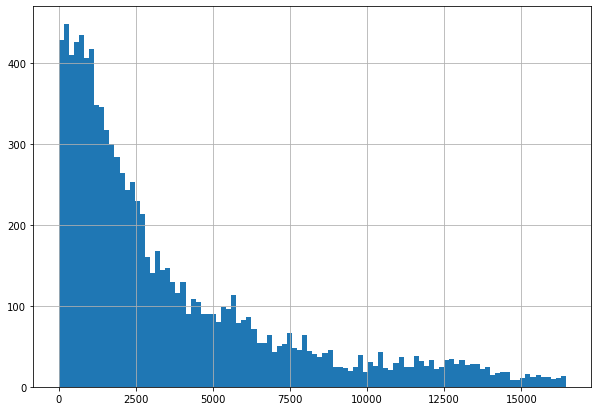

In [27]:
# Посмотрим распределение признака
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

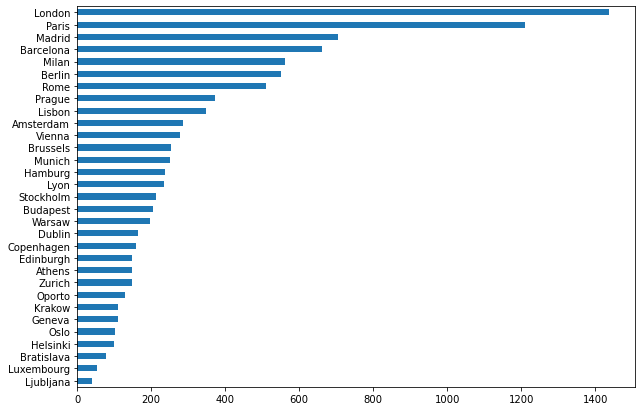

In [28]:
data['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

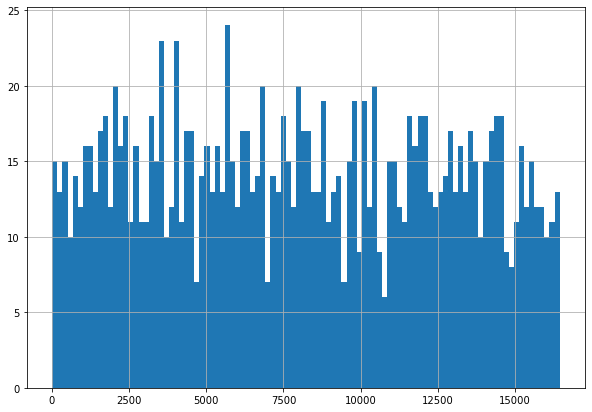

In [29]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

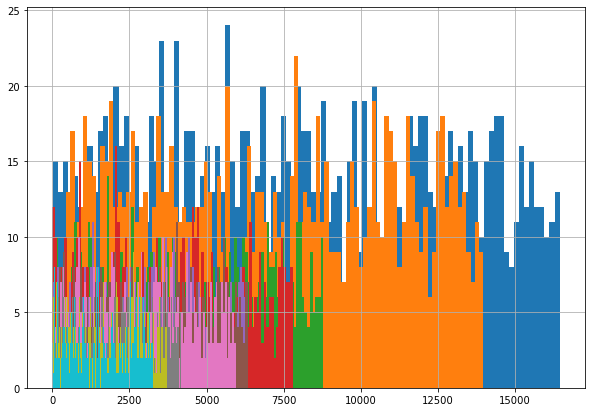

In [30]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Нормализуем переменную Ranking

In [34]:
# Создадим признак - количество ресторанов в городе city_restaurants
per_city_dict = dict(data['City'].value_counts())
data['city_restaurants'] = data.City.map(per_city_dict)
#display(per_city_dict)
display(data['city_restaurants'])

0        1211.0
1          99.0
2         149.0
3        1436.0
4          79.0
          ...  
49995       NaN
49996       NaN
49997       NaN
49998       NaN
49999       NaN
Name: city_restaurants, Length: 50000, dtype: float64

In [35]:
# Добавим признак - нормализованный ранг ranking_norm
data['ranking_norm'] = data.Ranking / data.city_restaurants

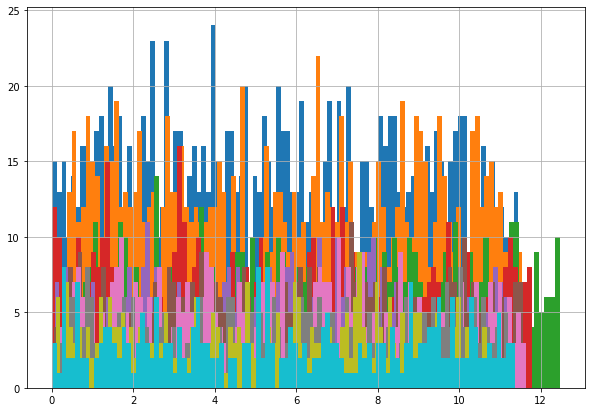

In [36]:
# Распределение после нормализации
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_norm'][data['City'] == x].hist(bins=100)
plt.show()

In [37]:
# Оставим для обучения модели только нормализованны ранг
data.drop(['Ranking'], axis=1, inplace=True)

### City

In [38]:
# Создадим dummy - переменные
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

## Reviews

Создадим новый признак - количество положительных слов в отзывах review_mood

In [37]:
good = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'friendly',
        'lovely', 'amazing', 'tasty', 'fantastic', 'perfect', 'wonderful',
        'super', 'awesome', 'love', 'beautiful', 'superb', 'interesting',
        'yummy', 'fine', 'favourite', 'surprise', 'loved', 'brilliant',
        'favorite']

data['words'] = data.Reviews.str.findall(r"(\w+)")
def mood(review):
    ''' Подсчет положительных слов в отзывах на ресторан.
    Возвращает количество положительных слов в отзывах. 
    '''
    i = 0
    for word in review:
        for mood in good:
            if mood == word.lower():
                i += 1
    return i
data['review_mood'] = data.words.dropna().apply(mood)
data.review_mood.fillna(0, inplace=True)

In [38]:
data.drop(['ID_TA'], axis=1, inplace=True)
data.drop(['URL_TA'], axis=1, inplace=True)

### Посмотрим распределение целевой переменной

<AxesSubplot:>

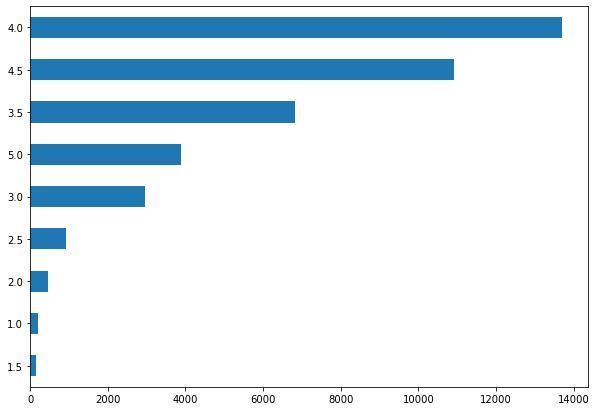

In [39]:
df_train['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

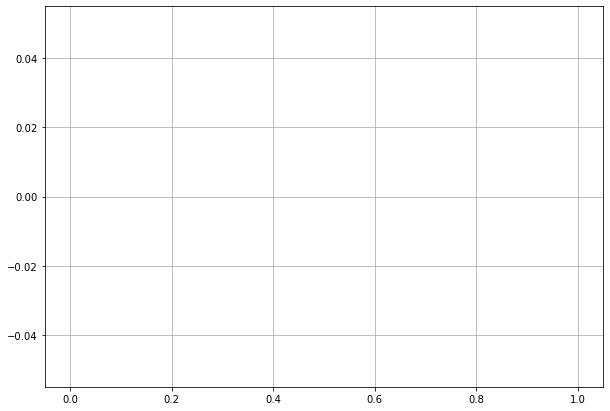

In [40]:
data['ranking_norm'][data['rating'] == 5].hist(bins=100)

Распределение напоминает нормальное

<AxesSubplot:>

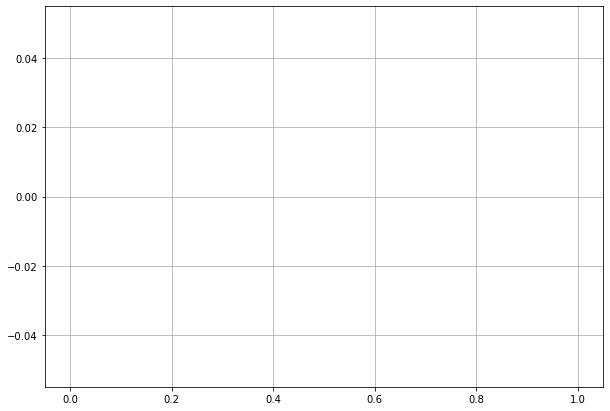

In [41]:
data['ranking_norm'][data['rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

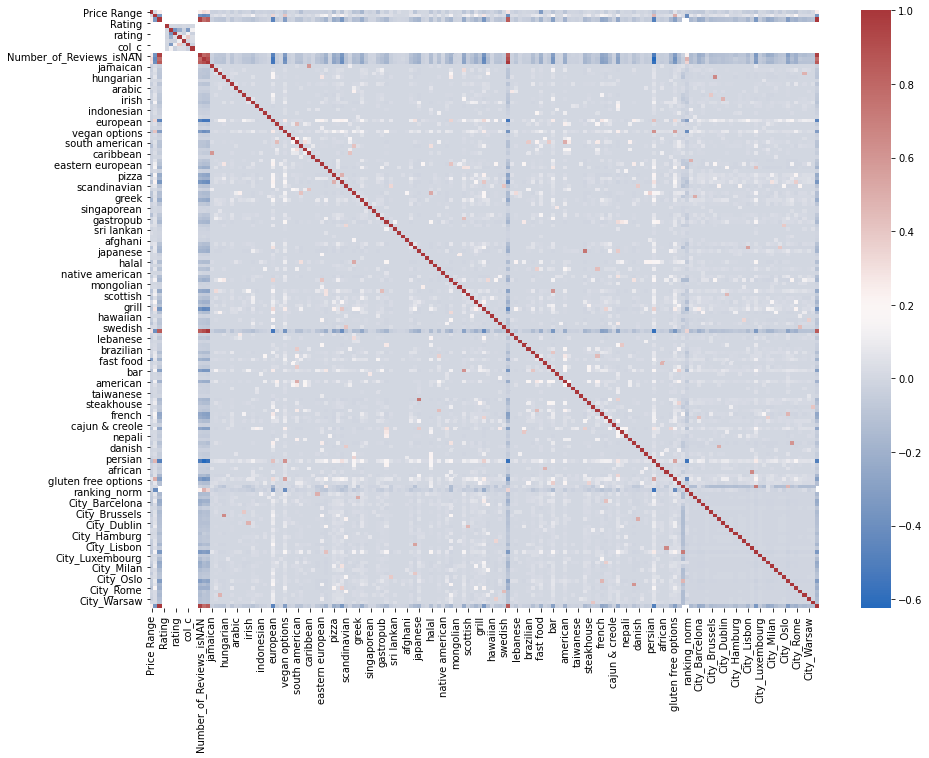

In [42]:
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(data.corr(), cmap='vlag')

In [41]:
data.corr().Rating.sort_values(ascending=False).to_frame()

,Rating
Price Range,NaN
Number of Reviews,NaN
sample,NaN
Rating,NaN
Unnamed: 0,NaN
...,...
City_Vienna,NaN
City_Warsaw,NaN
City_Zurich,NaN
City_nan,NaN


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [90]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('final.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data = df_train
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 138 entries, Unnamed: 0 to sample
dtypes: float64(3), int64(134), object(1)
memory usage: 42.1+ MB


In [91]:
data.columns
data

,Unnamed: 0,id,nor,prcat,col_c,col_r,city_le,city_restaurants,rank_norm,city_Amsterdam,...,city_Oslo.3,city_Paris.3,city_Prague.3,city_Rome.3,city_Stockholm.3,city_Vienna.3,city_Warsaw.3,city_Zurich.3,city_nan.3,sample
0,0,id_5569,194.0,2.0,3,2,24,4897,1.137431,0,...,0,1,0,0,0,0,0,0,0,1
1,1,id_1535,10.0,2.0,2,2,27,820,1.874390,0,...,0,0,0,0,1,0,0,0,0,1
2,2,id_352,688.0,3.0,7,2,16,5757,0.061317,0,...,0,0,0,0,0,0,0,0,0,1
3,3,id_3456,3.0,2.0,0,0,3,2155,1.604640,0,...,0,0,0,0,0,0,0,0,0,1
4,4,id_615,84.0,2.0,3,2,21,893,0.695409,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,id_499,79.0,2.0,4,2,20,2133,0.234412,0,...,0,0,0,0,0,0,0,0,0,1
39996,39996,id_6340,542.0,2.0,5,2,24,4897,1.294874,0,...,0,1,0,0,0,0,0,0,0,1
39997,39997,id_1649,4.0,2.0,2,2,27,820,2.014634,0,...,0,0,0,0,1,0,0,0,0,1
39998,39998,id_640,70.0,2.0,5,2,29,727,0.881706,0,...,0,0,0,0,0,0,1,0,0,1


In [92]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#    df_output.drop(['id_ta'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
#    df_output['Number of Reviews'].fillna(0, inplace=True)
#    df_output['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
#    replace_price_range = {'Price Range': {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}}
#    df_output.replace(replace_price_range, inplace=True)
#    df_output['Cuisine_Style_isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
 #   df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Unknown']")
    
    ### Немного Feature Engineering, потому что его надо делать раньше дамми переменных 

#    per_city_dict = dict(df_output['City'].value_counts())
#    df_output['city_restaurants'] = df_output.City.map(per_city_dict)

#    df_output['ranking_norm'] = df_output.Ranking / df_output.city_restaurants
    
#    good = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'friendly',
#        'lovely', 'amazing', 'tasty', 'fantastic', 'perfect', 'wonderful',
#        'super', 'awesome', 'love', 'beautiful', 'superb', 'interesting',
#        'yummy', 'fine', 'favourite', 'surprise', 'loved', 'brilliant',
 #       'favorite']

#    df_output['words'] = df_output.Reviews.str.findall(r"(\w+)")
#    def mood(review):
#        ''' Подсчет положительных слов в отзывах на ресторан.
#        Возвращает количество положительных слов в отзывах. 
#        '''
#        i = 0
#        for word in review:
#            for mood in good:
 #               if mood == word.lower():
 #                   i += 1
#        return i
#    df_output['review_mood'] = df_output.words.dropna().apply(mood)
#    df_output.review_mood.fillna(0, inplace=True)
    # ################### 3. Encoding ############################################################## 
#    df_output = pd.get_dummies(df_output, columns=[ 'city',], dummy_na=True)
#    def cuisine (df):
#        df['Cuisine Style'] = df['Cuisine Style'].str.lower()
#
#        cuisineStyle = set()
#        cuisines = df['Cuisine Style'].to_list()
#
 #       for cuisine in cuisines:
#            cuisine = re.findall(r"'([\s\S]+?)'", cuisine)
#           for j in cuisine:
#                 cuisineStyle.add(j)
#    
#        for item in cuisineStyle:
#            df[item] = df['Cuisine Style'].apply(lambda x: 1 if item in x else 0)
#        return df
#    df_output = cuisine(df_output)
    
    
    # ################### 4. Feature Engineering ####################################################
    chain_lst = list(df_output.id.value_counts()[df_output.id.value_counts() > 1].index)
    df_output['chain'] = df_output[data.id.isin(chain_lst)].id.apply(lambda x: 1)
    df_output['chain'].fillna(0, inplace=True)
    df_output['chain'] = df_output['chain'].astype(int)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [93]:
display(data.head(10))
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Unnamed: 0,id,nor,prcat,col_c,col_r,city_le,city_restaurants,rank_norm,city_Amsterdam,...,city_Oslo.3,city_Paris.3,city_Prague.3,city_Rome.3,city_Stockholm.3,city_Vienna.3,city_Warsaw.3,city_Zurich.3,city_nan.3,sample
0,0,id_5569,194.0,2.0,3,2,24,4897,1.137431,0,...,0,1,0,0,0,0,0,0,0,1
1,1,id_1535,10.0,2.0,2,2,27,820,1.874390,0,...,0,0,0,0,1,0,0,0,0,1
2,2,id_352,688.0,3.0,7,2,16,5757,0.061317,0,...,0,0,0,0,0,0,0,0,0,1
3,3,id_3456,3.0,2.0,0,0,3,2155,1.604640,0,...,0,0,0,0,0,0,0,0,0,1
4,4,id_615,84.0,2.0,3,2,21,893,0.695409,0,...,0,0,0,0,0,0,0,0,0,1
5,5,id_1418,2.0,2.0,3,2,22,513,2.766082,0,...,0,0,0,0,0,0,0,0,0,1
6,6,id_1720,50.0,1.0,2,2,20,2133,0.807314,0,...,0,0,0,0,0,0,0,0,0,1
7,7,id_825,9.0,2.0,1,2,4,301,2.744186,0,...,0,0,0,0,0,0,0,0,0,1
8,8,id_2690,0.0,2.0,2,0,28,1166,NaN,0,...,0,0,0,0,0,1,0,0,0,1
9,9,id_4209,55.0,1.0,3,2,26,2078,2.025987,0,...,0,0,0,1,0,0,0,0,0,1


,Unnamed: 0,nor,prcat,col_c,col_r,city_le,city_restaurants,rank_norm,city_Amsterdam,city_Athens,...,city_Paris.3,city_Prague.3,city_Rome.3,city_Stockholm.3,city_Vienna.3,city_Warsaw.3,city_Zurich.3,city_nan.3,sample,chain
34332,34332,446.0,2.0,3,2,22,513,0.274854,0,0,...,0,0,0,0,0,0,0,0,1,1
10224,10224,36.0,2.0,5,2,30,538,1.366171,0,0,...,0,0,0,0,0,0,1,0,1,1
4901,4901,15.0,2.0,0,2,24,4897,2.785787,0,0,...,1,0,0,0,0,0,0,0,1,0
18005,18005,6.0,2.0,1,2,27,820,2.825610,0,0,...,0,0,0,1,0,0,0,0,1,1
31270,31270,0.0,1.0,2,1,3,2155,NaN,0,0,...,0,0,0,0,0,0,0,0,1,1
13744,13744,11.0,2.0,1,2,19,3108,1.141248,0,0,...,0,0,0,0,0,0,0,0,1,1
35849,35849,18.0,2.0,1,0,19,3108,2.315959,0,0,...,0,0,0,0,0,0,0,0,1,1
20266,20266,2.0,2.0,2,1,7,659,2.344461,0,0,...,0,0,0,0,0,0,0,0,1,1
35406,35406,46.0,2.0,1,2,19,3108,1.184685,0,0,...,0,0,0,0,0,0,0,0,1,1
11316,11316,4.0,2.0,0,0,26,2078,2.512993,0,0,...,0,0,1,0,0,0,0,0,1,1


In [94]:
df_preproc.info()
df_preproc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 138 entries, Unnamed: 0 to chain
dtypes: float64(3), int32(1), int64(134)
memory usage: 42.0 MB


,Unnamed: 0,nor,prcat,col_c,col_r,city_le,city_restaurants,rank_norm,city_Amsterdam,city_Athens,...,city_Paris.3,city_Prague.3,city_Rome.3,city_Stockholm.3,city_Vienna.3,city_Warsaw.3,city_Zurich.3,city_nan.3,sample,chain
0,0,194.0,2.0,3,2,24,4897,1.137431,0,0,...,1,0,0,0,0,0,0,0,1,1
1,1,10.0,2.0,2,2,27,820,1.874390,0,0,...,0,0,0,1,0,0,0,0,1,1
2,2,688.0,3.0,7,2,16,5757,0.061317,0,0,...,0,0,0,0,0,0,0,0,1,1
3,3,3.0,2.0,0,0,3,2155,1.604640,0,0,...,0,0,0,0,0,0,0,0,1,1
4,4,84.0,2.0,3,2,21,893,0.695409,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,79.0,2.0,4,2,20,2133,0.234412,0,0,...,0,0,0,0,0,0,0,0,1,1
39996,39996,542.0,2.0,5,2,24,4897,1.294874,0,0,...,1,0,0,0,0,0,0,0,1,1
39997,39997,4.0,2.0,2,2,27,820,2.014634,0,0,...,0,0,0,1,0,0,0,0,1,1
39998,39998,70.0,2.0,5,2,29,727,0.881706,0,0,...,0,0,0,0,0,1,0,0,1,1


In [120]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = df_test.Rating.values            # наш таргет
#X = train_data.drop(['rating'], axis=1)
X = train_data.drop(['Unnamed: 0'], axis=1)
#X = train_data.drop(['rating'], axis=1)
display(X)

,nor,prcat,col_c,col_r,city_le,city_restaurants,rank_norm,city_Amsterdam,city_Athens,city_Barcelona,...,city_Oslo.3,city_Paris.3,city_Prague.3,city_Rome.3,city_Stockholm.3,city_Vienna.3,city_Warsaw.3,city_Zurich.3,city_nan.3,chain
0,194.0,2.0,3,2,24,4897,1.137431,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,10.0,2.0,2,2,27,820,1.874390,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,688.0,3.0,7,2,16,5757,0.061317,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,2.0,0,0,3,2155,1.604640,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,84.0,2.0,3,2,21,893,0.695409,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,79.0,2.0,4,2,20,2133,0.234412,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39996,542.0,2.0,5,2,24,4897,1.294874,0,0,0,...,0,1,0,0,0,0,0,0,0,1
39997,4.0,2.0,2,2,27,820,2.014634,0,0,0,...,0,0,0,0,1,0,0,0,0,1
39998,70.0,2.0,5,2,29,727,0.881706,0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [121]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

ValueError: Found input variables with inconsistent numbers of samples: [40000, 10000]

In [99]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((0, 137), (40000, 137), (40000, 108), (32000, 108), (8000, 108))

# Model 
Сам ML

In [100]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [101]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [102]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
